In [1]:
"""    
    Indicador: Porcentaje de Hectáreas actualizadas con respecto al total de hectáreas que deben actualizarse para cumplir un Hito contractual.
"""

'    \n    Indicador: Porcentaje de Hectáreas actualizadas con respecto al total de hectáreas que deben actualizarse para cumplir un Hito contractual.\n'

<h3>Importación Librerías</h3>

In [2]:
import pandas as pd
import os
import seaborn as sns
import shutil

os.environ["CRYPTOGRAPHY_OPENSSL_NO_LEGACY"] = "yes"

# ? Se usa para generar gráficos
import matplotlib.pyplot as plt

# ? Se usa para determina la fecha de ejecución del proceso dentro del export de los resultados estadísticos
from datetime import datetime

# ? Conexión a BD Postgres. Se usa dado que pandas no acepta sino este paquete para la conexión.
from sqlalchemy import create_engine, text

from datetime  import datetime as dt

from arcgis.features import GeoAccessor, GeoSeriesAccessor
import arcpy

from pathlib import Path

# ** Librerías propias
import funcion_dataframe_terrenos
import funcion_SQL_a_DataFrame
import funcion_parametrizacion_variables
import funcion_actualizacion_exportacion_seriemapa

<h3>Ejecución de Función de Variables</h3>

In [3]:
resultado = funcion_parametrizacion_variables.parametrizacion_variables()
consulta_tRadicados = resultado[0]
renombrar_actividades = resultado[4]

<h3>Parametrización de Variables</h3>

In [4]:

columnasRadicadoActualizacionCampo = ['municipio',
	'municipio_estandarizado',
	'zona',
	'npn',
	'radicado',
	'Proceso',
	'estado_tramite',
	'actividad',
	'usuario',
	'vr_proces_des']

columnas_espacializacion_radicadosActualizacionConNPNAtendiendoCampo = ['codigo',
	'codigo_anterior',                                                                        
	'municipio',
	'municipio_estandarizado',
	'zona',
    'Proceso',
	'radicado',
	'estado_tramite',
	'actividad',
	'usuario',
	'vr_proces_des',
	'area_ha_cmt12',
	'SHAPE']

L_MUNICIPIO = ['MariaLaBaja', 'Repelon', 'Baranoa', 'Sabanagrande']
NOMBRE_PROCESOS = ['Actualización','Conservación']
MUNICIPIO_FUENTE = ['MARIA LA ']

RUTA_BD_LOCAL = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuridica\2_2_0_Identificacion_Predial_Total_Ha_Actualizadas\Base_Datos\2_2_0.gdb"
RUTA_BD_CONSOLIDADA = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E1_Alistamiento_Diagnostico\3_Disposicion\1.BD_Consolidada\BD_Consolidada_Lote4.gdb"
NOMBRE_CAPA_HAXESTADO = 'TERRENOS_RECONOCIMIENTO_TRAMITES_ATENCION_BCGS'

XLSX_UNIFICADO = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuridica\2_2_0_Identificacion_Predial_Total_Ha_Actualizadas\zReportes\2_2_0_Identificacion_Predial_Total_Ha_Actualizadas.xlsx"

RUTA_RAIZ = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuridica\2_2_0_Identificacion_Predial_Total_Ha_Actualizadas\zReportes"
NOMBRE_IND_2_2_0 = 'Seguimiento_Diario'

DIRECTORIO_GRAFICO = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuridica\2_2_0_Identificacion_Predial_Total_Ha_Actualizadas\zReportes\Seguimiento_Grafico_Predio_X_Proceso"

fecha_actual = dt.now()
fecha_directorio = str(fecha_actual.strftime("%Y-%m-%d"))
fecha_directorio_w_Rendimiento = str(fecha_actual.strftime("%Y%m%d"))

# TODO: Alimenta el analisis en sistema de los radicados de Conservación
DIRECTORIO_SALIDA_XLSX = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuridica\2_2_2_Rendimientos_Reconocimiento"
NOMBRE_XLSX = fecha_directorio_w_Rendimiento + "_RendimientoEquipoReconocimiento_BCGS.xlsx"
RUTA_SALIDA_XLSX = os.path.join(DIRECTORIO_SALIDA_XLSX, NOMBRE_XLSX)
NOMBRE_HOJA = 'RADICADO_Conservacion_X_NPN'

renombrar_actividades = renombrar_actividades

dict_correcion_area_columna = {'area_ha_cmt12':'area_ha_ctm12'}

<h3>Ejecución de Funciones</h3>

In [5]:
#df_terrenos, ruta_terrenos = funcion_dataframe_terrenos.dataframe_terrenos()
df_consulta_radicados = funcion_SQL_a_DataFrame.sql_a_dataframe(consulta_tRadicados)

Inicio de la conexión
Conexión exitosa ...


<h3>Estandarización de actividades</h3>

In [6]:

for columna in df_consulta_radicados.columns:
    if columna == 'estado_tramite':
        for llave, valor in renombrar_actividades.items():
            df_consulta_radicados.loc[df_consulta_radicados[columna]==llave, columna] = valor

<h3>Generación de Campo Zona (Urbano/Rural) y Estandarización Campo Municipio</h3>

In [7]:

# TODO: Generacion Campo Zona
df_predios_radicados = df_consulta_radicados.copy()

df_predios_radicados['codigo_zona'] = df_predios_radicados['npn'].str[5:7]
df_predios_radicados['zona'] = None

df_predios_radicados.loc[df_predios_radicados['codigo_zona'] == '01', 'zona'] = 'Urbano'
df_predios_radicados.loc[df_predios_radicados['codigo_zona'] == '00', 'zona'] = 'Rural'
df_predios_radicados.loc[(df_predios_radicados['codigo_zona'] != '00') & (df_predios_radicados['codigo_zona'] != '01'), 'zona'] = 'Corregimientos Urbanos'

# TODO: Generacion Campo municipio_estandarizado
df_predios_radicados['municipio_estandarizado'] = None
df_predios_radicados.loc[df_predios_radicados['municipio'] == 'MARÍA LA BAJA', 'municipio_estandarizado'] = 'MariaLaBaja'
df_predios_radicados.loc[df_predios_radicados['municipio'] == 'REPELÓN', 'municipio_estandarizado'] = 'Repelon'
df_predios_radicados.loc[df_predios_radicados['municipio'] == 'BARANOA', 'municipio_estandarizado'] = 'Baranoa'
df_predios_radicados.loc[df_predios_radicados['municipio'] == 'SABANAGRANDE', 'municipio_estandarizado'] = 'Sabanagrande'

<h3>Total Radicados por Zona y Proceso [ATENDIENDO] </h3>

Se genera reporte para Indicador 5_2_PredActXZonaMariaLaBaja
Se genera XLSX de DF 5_2_PredActXZonaMariaLaBaja.xlsx
Se genera reporte para Indicador 5_3_PredActXZonaRepelon
Se genera XLSX de DF 5_3_PredActXZonaRepelon.xlsx
Se genera reporte para Indicador 5_1_PredActXZonaBaranoa
Se genera XLSX de DF 5_1_PredActXZonaBaranoa.xlsx
Se genera reporte para Indicador 5_4_PredActXZonaSabanagrande
Se genera XLSX de DF 5_4_PredActXZonaSabanagrande.xlsx


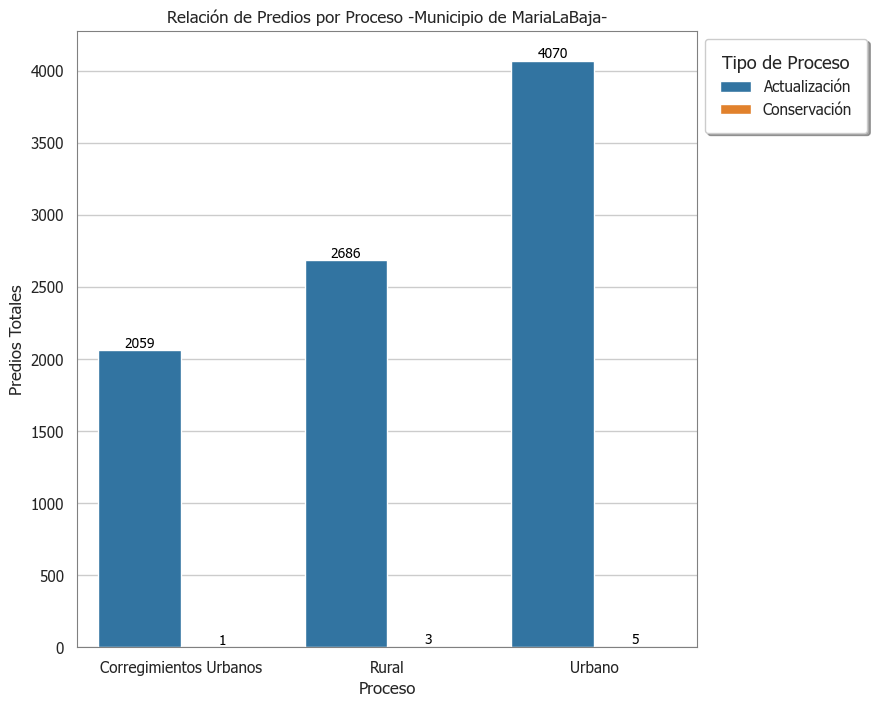

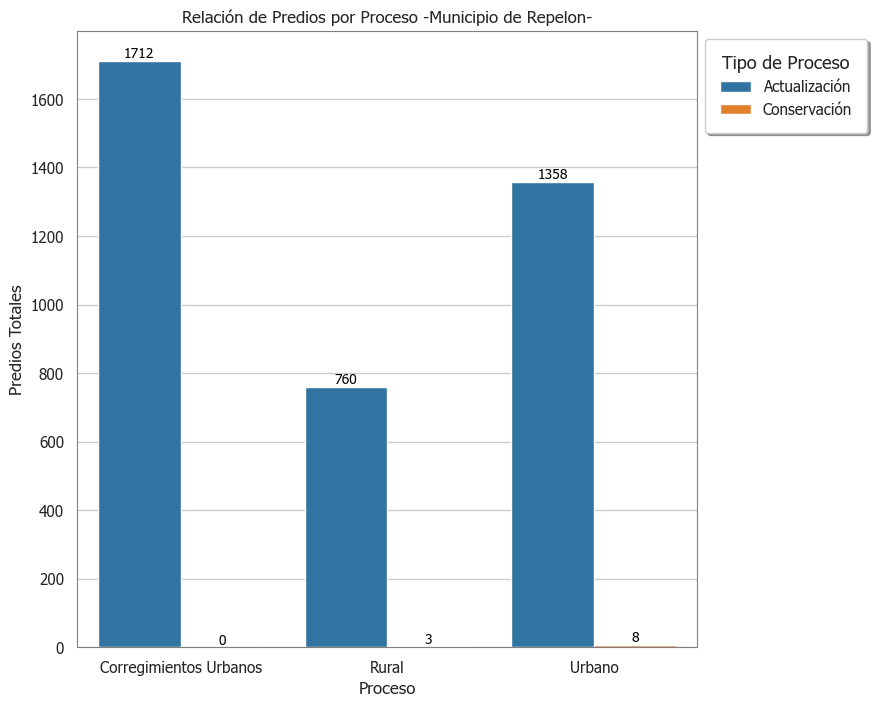

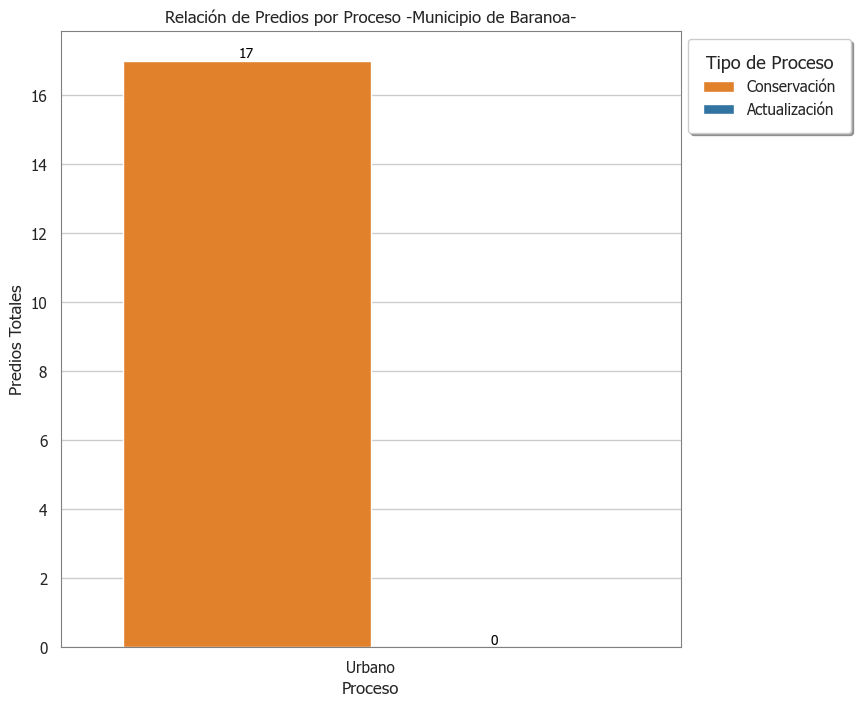

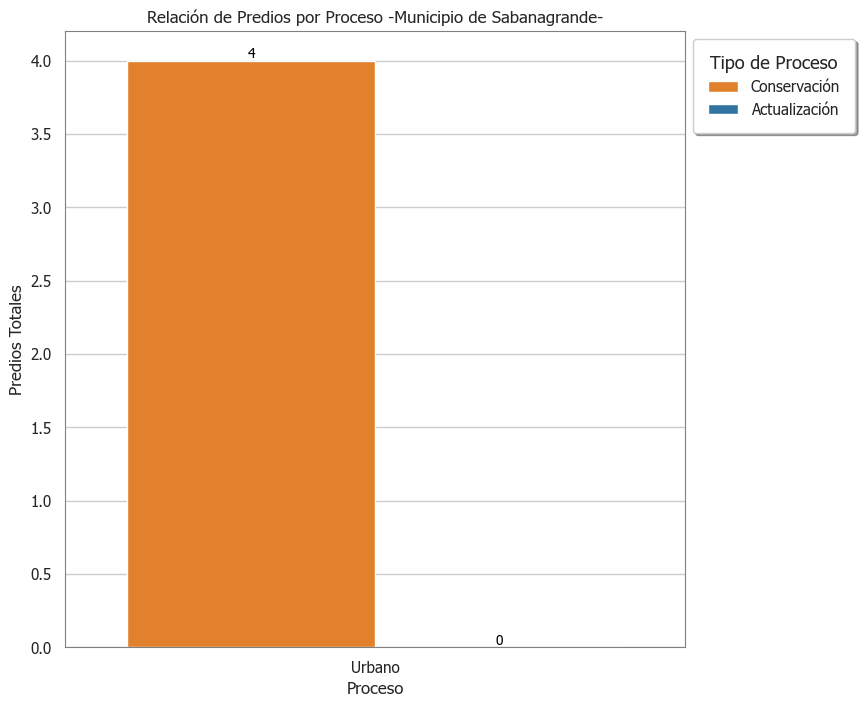

In [8]:

# ** Aplicar tema a la salida gráfica y tipo de texto y tamaño del texto
sns.set_theme(style='whitegrid', font='Tahoma', font_scale=1)

# ** Configuración ejes horizontales en Matplotlib
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.edgecolor'] = 'gray'
plt.rcParams['axes.linewidth'] = 0.8

paleta_colores = {
    'Actualización': '#1f77b4',  # Azul
    'Conservación': '#ff7f0e'    # Naranja
}

df_predios_radicados = df_predios_radicados[df_predios_radicados['vr_estado_paso']=='ATENDIENDO']
df_predios_radicados_x_proceso_x_zona = pd.DataFrame(df_predios_radicados[['municipio','Proceso','zona']].value_counts()).reset_index().rename(columns={'count':'total_predios'})

dataframes = {}

# ? ************ Creación de Conjuntos, almancenamiento de los mismos, para la redacción de los códigos de los indicadores ************
# * Rastrear los elementos únicos
elementos_vistos = set()

L_MUNICIPIOS = [(1,'MariaLaBaja'), (2,'Repelon'), (3,'Baranoa'), (4,'Sabanagrande')]

for id_municipio, nombre_municipio in L_MUNICIPIOS:
    if nombre_municipio not in elementos_vistos:
        elementos_vistos.add(nombre_municipio)

mi_lista = list(elementos_vistos)
mi_lista_ordenada = sorted(mi_lista)

for municipio in L_MUNICIPIO:
    query_municipio_zona = "municipio_estandarizado == "+"'"+municipio+"'"
    df = df_predios_radicados.query(query_municipio_zona)
    dataframes[municipio] = df

for municipio, df in dataframes.items():
    globals()[f'df_{municipio}'] = df
    globals()[f'df_{municipio}_Filtrado'] = pd.DataFrame(globals()[f'df_{municipio}'][['Proceso', 'zona']].value_counts().reset_index()).rename(columns={'count':'total_predios'})
    globals()[f'df_{municipio}_Filtrado_Pivote'] = globals()[f'df_{municipio}_Filtrado'].pivot(index="zona", columns="Proceso", values="total_predios")
    globals()[f'df_{municipio}_Filtrado_Pivote'] = globals()[f'df_{municipio}_Filtrado_Pivote'].reset_index()
    globals()[f'df_{municipio}_Filtrado_Pivote'] = globals()[f'df_{municipio}_Filtrado_Pivote'].fillna(0)

    # ** Usar ExcelWriter para guardar múltiples dataframes en diferentes hojas
    with pd.ExcelWriter(XLSX_UNIFICADO, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        for index, conjunto_mpio in enumerate(mi_lista_ordenada):
            # ? Para asignar el código de acuerdo a la tupla se realiza este condicional.
                if municipio == conjunto_mpio:
                    globals()[f'df_{municipio}_Filtrado_Pivote'].to_excel(writer, sheet_name='5_'+str(index+1)+'_PredActXZona'+municipio, index=True)
                    print(f"Se genera reporte para Indicador {'5_'+str(index+1)+'_PredActXZona'+municipio}")

                    l = [globals()[f'df_{municipio}_Filtrado_Pivote'], '5_'+str(index+1)+'_PredActXZona'+municipio+'.xlsx','5_'+str(index+1)+'PredActXZona'+municipio]

                    if os.path.exists(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_0, fecha_directorio)):
                        l[0].to_excel(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_0, fecha_directorio, l[1]), sheet_name=l[2])
                        print(f"Se genera XLSX de DF {'5_'+str(index+1)+'_PredActXZona'+municipio+'.xlsx'}")
                    else:
                        os.mkdir(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_0, fecha_directorio))     
                        l[0].to_excel(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_0, fecha_directorio, l[1]), sheet_name=l[2])
                        print(f"Se genera XLSX de DF {'5_'+str(index+1)+'_PredActXZona'+municipio+'.xlsx'}")
        
    f, ax = plt.subplots(figsize=(8, 8))

    if 'Actualización' in globals()[f'df_{municipio}_Filtrado_Pivote'].columns:
        if 'Conservación' in globals()[f'df_{municipio}_Filtrado_Pivote'].columns:
            pass
        else:
            globals()[f'df_{municipio}_Filtrado_Pivote']['Conservación'] = 0
    else:
        globals()[f'df_{municipio}_Filtrado_Pivote']['Actualización'] = 0        

    df_despivoteado = pd.melt(globals()[f'df_{municipio}_Filtrado_Pivote'], id_vars='zona', var_name='proceso', value_name='predios')

    # Mapear los colores usando el diccionario
    palette = [paleta_colores[x] for x in df_despivoteado['proceso'].unique()]

    sns.barplot(x='zona', y='predios', hue='proceso', data=df_despivoteado, ax=ax, palette=palette)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, color='black')

    ax.legend(
        title='Tipo de Proceso',      # Título de la leyenda
        title_fontsize='13',          # Tamaño de fuente del título
        loc='upper left',             # Ubicación de la leyenda
        fontsize='11',                # Tamaño de fuente de las etiquetas
        bbox_to_anchor=(1, 1),        # Coordenadas de anclaje para mover la leyenda fuera del gráfico
        frameon=True,                 # Mostrar marco alrededor de la leyenda
        shadow=True,                  # Añadir sombra al marco de la leyenda
        fancybox=True,                # Hacer el marco redondeado
        borderpad=1                   # Espaciado entre el contenido y el marco
    )

    # * Ajustar las etiquetas y el título
    ax.set_title(f'Relación de Predios por Proceso -Municipio de {municipio}-')
    ax.set_xlabel('Proceso')
    ax.set_ylabel('Predios Totales')
    
    NOMBRE_GRAFICO = municipio + '_Predio_X_Proceso.png'
    ruta_grafico = os.path.join(DIRECTORIO_GRAFICO, NOMBRE_GRAFICO)

    plt.savefig(ruta_grafico, dpi=300, bbox_inches='tight')

<h3>Predios Atendiendo por Parte de Conservación</h3>

In [9]:
df_radicadosConNPNAtendiendo = df_predios_radicados[(df_predios_radicados['npn'].notnull()) & (df_predios_radicados['vr_estado_paso'] == 'ATENDIENDO') &
    (df_predios_radicados['Proceso'] == 'Conservación')]

df_radicadosConNPNAtendiendoCampo = df_radicadosConNPNAtendiendo[columnasRadicadoActualizacionCampo]
print(f" 1. El total de trámites, en Conservación y que están siendo atendidos son: {df_radicadosConNPNAtendiendo.shape[0]}")

with pd.ExcelWriter(RUTA_SALIDA_XLSX, engine='openpyxl', mode='a', if_sheet_exists='new') as writer:
    df_radicadosConNPNAtendiendoCampo.to_excel(writer, sheet_name=NOMBRE_HOJA, index=False)

 1. El total de trámites, en Conservación y que están siendo atendidos son: 41


<h3>Predios en Atención (ESPACIALIZACIÓN), Conservación y Actualización</h3>

In [10]:
RUTA_CAPA_TERRENOS = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E1_Alistamiento_Diagnostico\3_Disposicion\1.BD_Consolidada\BD_Consolidada_Lote4.gdb\Analitica_UT_Consolidada\TERRENO_POR_HITO"
df_terrenos = pd.DataFrame.spatial.from_featureclass(RUTA_CAPA_TERRENOS)

df_radicadosConNPNAtendiendo = df_predios_radicados[(df_predios_radicados['npn'].notnull()) & (df_predios_radicados['vr_estado_paso'] == 'ATENDIENDO')]

df_terrenos_radicadosConNPNAtendiendoCampo = pd.merge(left=df_terrenos, right=df_radicadosConNPNAtendiendo, left_on="codigo", right_on="npn", how="inner")

# # TODO: ExportacionTramitesEnAtencionXEstado
# ** Exportación a BD Consolidada
NOMBRE_CAPA_SALIDA = f"Analitica_UT_Consolidada\\{NOMBRE_CAPA_HAXESTADO.upper()}"
ruta_salida_terrenos_ha_x_estado = os.path.join(RUTA_BD_CONSOLIDADA, NOMBRE_CAPA_SALIDA)

df_terrenos_radicadosConNPNAtendiendoCampo.spatial.to_featureclass(location=ruta_salida_terrenos_ha_x_estado)
print(f"Se exporta la capa {NOMBRE_CAPA_SALIDA} a BD Consolidada")

# ** Exportación a BD Seguimiento Indicadores
df_terrenos_radicadosConNPNAtendiendoCampo.spatial.to_featureclass(location=os.path.join(RUTA_BD_LOCAL,NOMBRE_CAPA_HAXESTADO))
print(f"Se exporta la capa {NOMBRE_CAPA_SALIDA} a BD Local 2.2.0")

cannot add field: 'fecha_radicado'
Se exporta la capa Analitica_UT_Consolidada\TERRENOS_RECONOCIMIENTO_TRAMITES_ATENCION_BCGS a BD Consolidada
cannot add field: 'fecha_radicado'
Se exporta la capa Analitica_UT_Consolidada\TERRENOS_RECONOCIMIENTO_TRAMITES_ATENCION_BCGS a BD Local 2.2.0


<h3>Cálculo de Hectáreas [Atendiendo por Actualización]</h3>

In [11]:

# TODO: Actualización
# ** Mejora de la tabla
df_radicadosConNPNAtendiendoCampo = df_terrenos_radicadosConNPNAtendiendoCampo[columnas_espacializacion_radicadosActualizacionConNPNAtendiendoCampo]
# ** Filtro de registros asociados a la Actualización
df_radicadosActualizacionConNPNAtendiendoCampo = df_radicadosConNPNAtendiendoCampo[df_radicadosConNPNAtendiendoCampo['Proceso'] == 'Actualización']

In [12]:
df_radicadosActualizacionConNPNAtendiendoCampo_municipio_has = df_radicadosActualizacionConNPNAtendiendoCampo.groupby(['municipio_estandarizado','zona','estado_tramite'])['area_ha_cmt12'].sum()
df_radicadosConNPNAtendiendoCampo_municipio_has = pd.DataFrame(df_radicadosActualizacionConNPNAtendiendoCampo_municipio_has).reset_index().round(2)
df_radicadosConNPNAtendiendoCampo_municipio_has = df_radicadosConNPNAtendiendoCampo_municipio_has.rename(columns=dict_correcion_area_columna)

<h3>Calculo de Hectáreas: Actualizacion - Actualización - Atendiendo - Zona - En SIG</h3>

In [13]:
# df_radicadosActualizacionConNPNAtendiendoCampo = df_radicadosActualizacionConNPNAtendiendoCampo[(df_radicadosActualizacionConNPNAtendiendoCampo['estado_tramite'] == '6.Preparando Edición Geográfica') | 
#                                                                                                 (df_radicadosActualizacionConNPNAtendiendoCampo['estado_tramite'] == '7.Realizando Edición Geográfica') |
#                                                                                                 (df_radicadosActualizacionConNPNAtendiendoCampo['estado_tramite'] == '8.Revisando Información Geográfica')]

df_radicadosActualizacionConNPNAtendiendoCampo_municipio_zona_has = df_radicadosActualizacionConNPNAtendiendoCampo.groupby(['municipio_estandarizado','zona'])['area_ha_cmt12'].sum()
df_radicadosActualizacionConNPNAtendiendoCampo_municipio_zona_has = pd.DataFrame(df_radicadosActualizacionConNPNAtendiendoCampo_municipio_zona_has).reset_index().round(2)
df_radicadosActualizacionConNPNAtendiendoCampo_municipio_zona_has = df_radicadosActualizacionConNPNAtendiendoCampo_municipio_zona_has.rename(columns=dict_correcion_area_columna)

# ** Total de Ha En el Estado de Atención Componente SIG
df_radicadosActualizacionConNPNAtendiendoCampo_municipio_zona_has_pivote = df_radicadosActualizacionConNPNAtendiendoCampo_municipio_zona_has.pivot(index="zona", columns="municipio_estandarizado", values="area_ha_ctm12")
df_radicadosConNPNAtendiendoCampo_municipio_zona_has_pivote =  df_radicadosActualizacionConNPNAtendiendoCampo_municipio_zona_has_pivote.fillna(0)

In [14]:

# ** Usar ExcelWriter para guardar múltiples dataframes en diferentes hojas
with pd.ExcelWriter(XLSX_UNIFICADO, engine='xlsxwriter') as writer:
    df_radicadosConNPNAtendiendoCampo_municipio_has.to_excel(writer, sheet_name='16_TotalHAActuaXMpio', index=True)
    df_radicadosConNPNAtendiendoCampo_municipio_zona_has_pivote.to_excel(writer, sheet_name='17_TotalHAActuaXMpioXZona', index=True)

print(f"Se genera XLSX Unificado {XLSX_UNIFICADO}")

Se genera XLSX Unificado C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuridica\2_2_0_Identificacion_Predial_Total_Ha_Actualizadas\zReportes\2_2_0_Identificacion_Predial_Total_Ha_Actualizadas.xlsx


In [15]:

dir_directorio_salidas_xlsx = {1:[df_radicadosConNPNAtendiendoCampo_municipio_has,'16_TotalHAActuaXMpio.xlsx','16_TotalHAActuaXMpio'],
    2:[df_radicadosConNPNAtendiendoCampo_municipio_zona_has_pivote,'17_TotalHAActuaXMpioXZona.xlsx','17_TotalHAActuaXMpioXZona'],
    }

if os.path.exists(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_0, fecha_directorio)):
    for llave, valor in dir_directorio_salidas_xlsx.items():
        valor[0].to_excel(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_0, fecha_directorio, valor[1]), sheet_name=valor[2])
        print(f"Se genera XLSX de DF {valor[1]}")
else:
    os.mkdir(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_0, fecha_directorio))
    for llave, valor in dir_directorio_salidas_xlsx.items():
        valor[0].to_excel(os.path.join(RUTA_RAIZ, NOMBRE_IND_2_2_0, fecha_directorio, valor[1]), sheet_name=valor[2])
        print(f"Se genera XLSX de DF {valor[1]}")

Se genera XLSX de DF 16_TotalHAActuaXMpio.xlsx
Se genera XLSX de DF 17_TotalHAActuaXMpioXZona.xlsx


<h3>Actualización Mapa y Generación de PDF</h3>

In [16]:
funcion_actualizacion_exportacion_seriemapa.ejecutar_actualizaciones()

Nombre Layout: Seguimiento Indicadores [Ha] Visitadas Fuente BCGS X MPIO
Se exporta a PDF Seguimiento Indicadores [Ha] Visitadas Fuente BCGS X MPIO
Nombre Layout: Seguimiento Indicadores [Ha] Visitadas Fuente BCGS X UI Urbano
Se exporta a PDF Seguimiento Indicadores [Ha] Visitadas Fuente BCGS X UI Urbano
